In [ ]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import date, timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from scipy.stats import skew, kurtosis

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

Code below is based on 

- https://github.com/cerlymarco/MEDIUM_NoteBook/blob/master/Graph_TimeSeries_Forecasting/Graph_TimeSeries_Forecasting.ipynb
- the above comes from https://towardsdatascience.com/time-series-forecasting-with-graph-convolutional-neural-network-7ffb3b70afcf
- https://github.com/danielegrattarola/spektral/blob/master/examples/node_prediction/citation_gat.py

In [271]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

In [61]:
from spektral_utilities import *
from spektral_gcn import GraphConv

from spektral.layers import GCNConv


In [326]:
### UTILITY FUNCTIONS FOR FEATURE ENGINEERING ###

sequence_length = 48 # play with this

def get_timespan(df, today, days):    
    df = df[pd.date_range(today - timedelta(days=days), 
            periods=days, freq='D')] # day - n_days <= dates < day    
    return df

def create_features(df, today, seq_len):
    
    all_sequence = get_timespan(df, today, seq_len).values
    
    group_store = all_sequence.reshape((-1, 10, seq_len))
    
    store_corr = np.stack([np.corrcoef(i) for i in group_store], axis=0)
    
    store_features = np.stack([
              group_store.mean(axis=2),
              group_store[:,:,int(sequence_length/2):].mean(axis=2),
              group_store.std(axis=2),
              group_store[:,:,int(sequence_length/2):].std(axis=2),
              skew(group_store, axis=2),
              kurtosis(group_store, axis=2),
              np.apply_along_axis(lambda x: np.polyfit(np.arange(0, sequence_length), x, 1)[0], 2, group_store)
            ], axis=1)
    
    group_store = np.transpose(group_store, (0,2,1))
    store_features = np.transpose(store_features, (0,2,1))
    
    return group_store, store_corr, store_features

def create_label(df, today):
    
    y = df[today].values
    
    return y.reshape((-1, 10))

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


In [327]:
### READ DATA ###

df = pd.read_csv('../dataset/SalesGNNTimeSeries/sales_train.csv.zip')
df['date'] = pd.to_datetime(df['date'])

print(df.shape)
df.head()

(913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [328]:
### SWITCH DATA FROM VERTICAL TO HORIZONTAL FORMAT ###

unstaked_df = df.copy()
unstaked_df['id'] = df['item'].astype(str)+'_'+df['store'].astype(str)
unstaked_df.set_index(['id','date'], inplace=True)
unstaked_df.drop(['store','item'], axis=1, inplace=True)
unstaked_df = unstaked_df.astype(float).unstack()
unstaked_df.columns = unstaked_df.columns.get_level_values(1)

print(unstaked_df.shape)
unstaked_df.head()

(500, 1826)


date,2013-01-01,2013-01-02,2013-01-03,2013-01-04,2013-01-05,2013-01-06,2013-01-07,2013-01-08,2013-01-09,2013-01-10,...,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31
id,,,,,,,,,,,,,,,,,,,,,
10_1,37.0,34.0,32.0,45.0,35.0,54.0,37.0,37.0,32.0,36.0,...,60.0,67.0,88.0,42.0,50.0,55.0,63.0,56.0,78.0,74.0
10_10,45.0,50.0,53.0,51.0,54.0,54.0,54.0,40.0,50.0,53.0,...,64.0,74.0,66.0,61.0,53.0,72.0,81.0,69.0,86.0,67.0
10_2,51.0,56.0,46.0,56.0,53.0,68.0,37.0,47.0,65.0,61.0,...,86.0,114.0,84.0,66.0,69.0,63.0,78.0,76.0,77.0,116.0
10_3,38.0,60.0,50.0,46.0,46.0,52.0,40.0,41.0,32.0,38.0,...,83.0,71.0,101.0,45.0,61.0,51.0,56.0,61.0,72.0,68.0
10_4,30.0,29.0,37.0,45.0,52.0,58.0,29.0,44.0,53.0,39.0,...,75.0,64.0,86.0,56.0,54.0,57.0,53.0,65.0,74.0,69.0


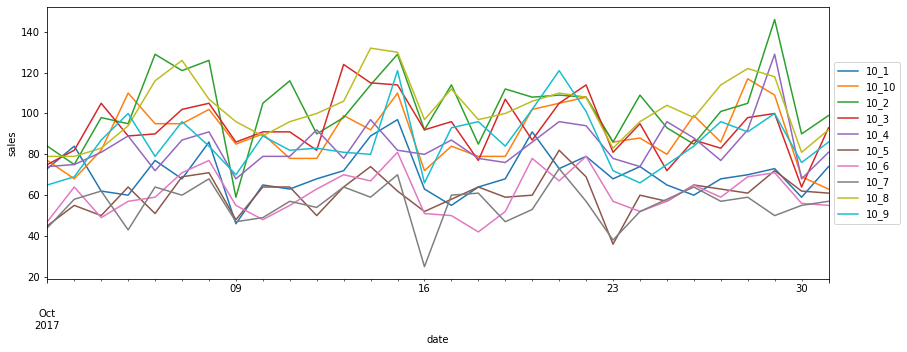

In [329]:
### PLOT A SEQUENCE OF SALES FOR ITEM 10 IN ALL STORES ###

sequence = get_timespan(unstaked_df, date(2017,11,1), 30)
sequence.head(10).T.plot(figsize=(14,5))
plt.ylabel('sales')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [330]:
### DEFINE TRAIN, VALID, TEST DATES ###

train_date = date(2013, 1, 1)
valid_date = date(2015, 1, 1)
test_date = date(2016, 1, 1)

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(train_date+timedelta(days=sequence_length), valid_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_train_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_train_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_train_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_train = np.concatenate(y, axis=0).astype('float16')

print(X_train_seq.shape, X_train_cor.shape, X_train_feat.shape, y_train.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 683/683 [00:25<00:00, 26.50it/s]


(34150, 48, 10) (34150, 10, 10) (34150, 10, 7) (34150, 10)


In [331]:
### CREATE VALID FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(valid_date+timedelta(days=sequence_length), test_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_valid_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_valid_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_valid_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_valid = np.concatenate(y, axis=0).astype('float16')

print(X_valid_seq.shape, X_valid_cor.shape, X_valid_feat.shape, y_valid.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 318/318 [00:11<00:00, 26.52it/s]

(15900, 48, 10) (15900, 10, 10) (15900, 10, 7) (15900, 10)


In [332]:
X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(test_date+timedelta(days=sequence_length), date(2016,12,31))):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_test_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_test_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_test_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_test = np.concatenate(y, axis=0).astype('float16')

print(X_test_seq.shape, X_test_cor.shape, X_test_feat.shape, y_test.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 318/318 [00:11<00:00, 27.09it/s]


(15900, 48, 10) (15900, 10, 10) (15900, 10, 7) (15900, 10)


In [333]:
# Scale sequences

scaler_seq = StandardScaler()
scaler_feat = StandardScaler()

X_train_seq = scaler_seq.fit_transform(X_train_seq.reshape(-1,10)).reshape(X_train_seq.shape)
X_valid_seq = scaler_seq.transform(X_valid_seq.reshape(-1,10)).reshape(X_valid_seq.shape)
X_test_seq = scaler_seq.transform(X_test_seq.reshape(-1,10)).reshape(X_test_seq.shape)

y_train = scaler_seq.transform(y_train)
y_valid = scaler_seq.transform(y_valid)
y_test = scaler_seq.transform(y_test)

X_train_feat = scaler_feat.fit_transform(X_train_feat.reshape(-1,10)).reshape(X_train_feat.shape)
X_valid_feat = scaler_feat.transform(X_valid_feat.reshape(-1,10)).reshape(X_valid_feat.shape)
X_test_feat = scaler_feat.transform(X_test_feat.reshape(-1,10)).reshape(X_test_feat.shape)

In [334]:
(X_train_seq.reshape(-1,10)).shape

(1639200, 10)

In [335]:
y_train.shape

(34150, 10)

In [336]:
X_train_feat.shape

(34150, 10, 7)

In [337]:
X_train_seq.shape

(34150, 48, 10)

In [338]:
np.save('../features/SalesGNNTimeSeries/X_train_feat.npy', X_train_feat)
np.save('../features/SalesGNNTimeSeries/X_valid_feat.npy', X_valid_feat)
np.save('../features/SalesGNNTimeSeries/X_test_feat.npy', X_test_feat)

np.save('../features/SalesGNNTimeSeries/X_train_seq.npy', X_train_seq)
np.save('../features/SalesGNNTimeSeries/X_valid_seq.npy', X_valid_seq)
np.save('../features/SalesGNNTimeSeries/X_test_seq.npy', X_test_seq)

np.save('../features/SalesGNNTimeSeries/y_train.npy', y_train)
np.save('../features/SalesGNNTimeSeries/y_valid.npy', y_valid)
np.save('../features/SalesGNNTimeSeries/y_test.npy', y_test)

In [339]:
### OBTAIN LAPLACIANS FROM CORRELATIONS ###

X_train_lap = localpooling_filter(1 - np.abs(X_train_cor))
X_valid_lap = localpooling_filter(1 - np.abs(X_valid_cor))
X_test_lap = localpooling_filter(1 - np.abs(X_test_cor))

In [30]:
def get_model():
    set_seed(33)

    opt = Adam(lr=0.001)

    inp_seq = Input((sequence_length, 10))
    inp_lap = Input((10, 10))
    inp_feat = Input((10, X_train_feat.shape[-1]))

    x = GCNConv(32, activation='relu')([inp_feat, inp_lap])
    x = GCNConv(16, activation='relu')([x, inp_lap])
    x = Flatten()(x)

    xx = LSTM(128, activation='relu', return_sequences=True)(inp_seq)
    xx = LSTM(32, activation='relu')(xx)

    x = Concatenate()([x,xx])
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(1)(x)

    model = Model([inp_seq, inp_lap, inp_feat], out)
    model.compile(optimizer=opt, loss='mse', 
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

In [83]:
def get_encoder():
    latent_dim = 2

    inp_seq = keras.Input((sequence_length, 10))
    inp_lap = keras.Input((10, 10))
    inp_feat = keras.Input((10, X_train_feat.shape[-1]))

    encoder_inputs = [inp_seq, inp_lap, inp_feat]

    x = GCNConv(32, activation='relu')([inp_feat, inp_lap])
    x = GCNConv(16, activation='relu')([x, inp_lap])
    x = layers.Flatten()(x)

    xx = LSTM(128, activation='relu', return_sequences=True)(inp_seq)
    xx = LSTM(32, activation='relu')(xx)

    x = Concatenate()([x,xx])
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

encoder = get_encoder()
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_80 (InputLayer)          [(None, 10, 7)]      0           []                               
                                                                                                  
 input_79 (InputLayer)          [(None, 10, 10)]     0           []                               
                                                                                                  
 gcn_conv_61 (GCNConv)          (None, 10, 32)       256         ['input_80[0][0]',               
                                                                  'input_79[0][0]']               
                                                                                                  
 input_78 (InputLayer)          [(None, 14, 10)]     0           []                         

In [42]:
inp_seq.shape

TensorShape([None, 14, 10])

In [91]:
# GCNConv
#|  **Input**
#|  
#|  - Node features of shape `([batch], n_nodes, n_node_features)`;
#|  - Modified Laplacian of shape `([batch], n_nodes, n_nodes)`; can be computed with
#|  `spektral.utils.convolution.gcn_filter`.
#|  
#|  **Output**
#|  
#|  - Node features with the same shape as the input, but with the last
#|  dimension changed to `channels`.

def get_decoder():
    #inp_lap_out = keras.Input((10, 10))

    latent_inputs = keras.Input(shape=(latent_dim,))

    #concatenated_input = layers.concatenate([latent_inputs, inp_lap])

    x = layers.Dense(28, activation="relu")(latent_inputs)

    x_lstm = layers.Reshape((14, 2))(x)

    x_lstm = LSTM(10, activation='relu', return_sequences=True)(x_lstm)
    #x_lstm = LSTM(128, activation='relu', return_sequences=True)(x_lstm)

    x_gnn = layers.Dense(160, activation="relu")(latent_inputs)
    x_lap = layers.Dense(100, activation="relu")(latent_inputs)
    
    x_gnn = layers.Reshape((10, 16))(x_gnn)
    x_lap = layers.Reshape((10, 10))(x_lap)
    
    x_gnn = GCNConv(16, activation='relu')([x_gnn, x_lap])
    x_gnn = GCNConv(7, activation='relu')([x_gnn, x_lap])
    decoder_outputs = [x_lstm, x_lap, x_gnn]
    decoder = keras.Model([latent_inputs], decoder_outputs, name="decoder")
    #decoder_gnn = keras.Model([latent_inputs], [x_gnn], name="decoder")
    return decoder

decoder = get_decoder()
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_83 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 dense_107 (Dense)              (None, 100)          300         ['input_83[0][0]']               
                                                                                                  
 dense_106 (Dense)              (None, 160)          480         ['input_83[0][0]']               
                                                                                                  
 dense_105 (Dense)              (None, 28)           84          ['input_83[0][0]']               
                                                                                            

In [103]:
decoder.compute_output_shape([(100, 2)])

[TensorShape([100, 14, 10]),
 TensorShape([100, 10, 10]),
 TensorShape([100, 10, 7])]

In [105]:
encoder.input_shape

[(None, 14, 10), (None, 10, 10), (None, 10, 7)]

In [47]:
tuple(list(inp_seq.shape))

(None, 14, 10)

In [38]:
inp_lap.shape

TensorShape([None, 10, 10])

In [37]:
inp_feat.shape

TensorShape([None, 10, 7])

In [246]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
class Encoder(layers.Layer):
    """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, ts_sequence_length, num_ts_features, latent_dim=2, intermediate_dim=64, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        #latent_dim = 2

        self.ts_sequence_length = ts_sequence_length
        self.num_ts_features = num_ts_features
        self.inp_seq = keras.Input((self.ts_sequence_length, 10))
        self.inp_lap = keras.Input((10, 10))
        self.inp_feat = keras.Input((10, self.num_ts_features))

        self.encoder_inputs = [self.inp_seq, self.inp_lap, self.inp_feat]
        
        self.gcn_conv1 = GCNConv(32, activation=layers.LeakyReLU(alpha=0.01))
        self.gcn_conv2 = GCNConv(16, activation=layers.LeakyReLU(alpha=0.01))
        
        self.flatten_layer = layers.Flatten()
        
        self.lstm1 = LSTM(128, activation=layers.LeakyReLU(alpha=0.01), return_sequences=True)
        self.lstm2 = LSTM(32, activation=layers.LeakyReLU(alpha=0.01))
        
        self.concat_layer = Concatenate()
        self.batch_norm_layer = BatchNormalization()
        
        self.dropout1 = Dropout(0.1)
        self.fully_connected1 = layers.Dense(intermediate_dim, activation=layers.LeakyReLU(alpha=0.01))
        self.dropout2 = Dropout(0.1)
        
        self.dense_mean = layers.Dense(latent_dim, name="z_mean")
        self.dense_log_var = layers.Dense(latent_dim, name="z_log_var")
        self.sampling = Sampling()

    def call(self, inputs):
        self.inp_seq = inputs[0]
        self.inp_feat = inputs[2]
        self.inp_lap = inputs[1]
        
        x = self.gcn_conv1([self.inp_feat, self.inp_lap])
        x = self.gcn_conv2([x, self.inp_lap])
        x = self.flatten_layer(x)

        xx = self.lstm1(self.inp_seq)
        xx = self.lstm2(xx)

        x = self.concat_layer([x,xx])
        x = self.batch_norm_layer(x)
        x = self.dropout1(x)
        x = self.fully_connected1(x)
        x = self.dropout2(x)

        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))

        return z_mean, z_log_var, z


class Decoder(layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""

    def __init__(self, original_dim, latent_dim=2, intermediate_dim=64, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)        
        self.latent_inputs = keras.Input(shape=(latent_dim,))
        
        self.fully_connected_lstm = layers.Dense(28, activation=layers.LeakyReLU(alpha=0.01))
        self.reshape_layer_lstm = layers.Reshape((14, 2))
        self.lstm_layer1 = LSTM(10, activation=layers.LeakyReLU(alpha=0.01), return_sequences=True)
        self.lstm_layer2 = LSTM(128, activation=layers.LeakyReLU(alpha=0.01), return_sequences=True)
        
        self.fully_connected_gcn1 = layers.Dense(160, activation=layers.LeakyReLU(alpha=0.01))
        self.fully_connected_lap1 = layers.Dense(100, activation=layers.LeakyReLU(alpha=0.01))
        
        self.reshape_layer_gcn = layers.Reshape((10, 16))
        self.reshape_layer_lap = layers.Reshape((10, 10))
        
        self.gcn_layer1 = GCNConv(16, activation=layers.LeakyReLU(alpha=0.01))
        self.gcn_layer2 = GCNConv(7, activation=layers.LeakyReLU(alpha=0.01))

    def call(self, inputs):
        x_lstm = self.fully_connected_lstm(inputs)
        x_lstm = self.reshape_layer_lstm(x_lstm)

        x_lstm = self.lstm_layer1(x_lstm)
        #x_lstm = self.lstm_layer2(x_lstm)

        x_lap = self.fully_connected_lap1(inputs)
        x_lap = self.reshape_layer_lap(x_lap)
        
        x_gnn = self.fully_connected_gcn1(inputs)
        x_gnn = self.reshape_layer_gcn(x_gnn)
        x_gnn = self.gcn_layer1([x_gnn, x_lap])
        x_gnn = self.gcn_layer2([x_gnn, x_lap])
        return x_lstm, x_lap, x_gnn

class VAE(keras.Model):
    def __init__(self, 
                 original_dim,
                 ts_sequence_length,
                 num_ts_features,
                 intermediate_dim=64,
                 latent_dim=2,
                 name="variational-autoencoder",
                 **kwargs):
        super(VAE, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(ts_sequence_length=ts_sequence_length, num_ts_features=num_ts_features, latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        #self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        #self.reconstruction_loss_tracker = keras.metrics.Mean(
        #    name="reconstruction_loss"
        #)
        #self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    #@property
    #def metrics(self):
    #    return [
    #        self.total_loss_tracker,
    #        self.reconstruction_loss_tracker,
    #        self.kl_loss_tracker,
    #    ]

    def call(self, inputs):
        #with tf.GradientTape() as tape:
        z_mean, z_log_var, z = self.encoder(inputs)
        #print(data[0][0])
        reconstruction = self.decoder(z)
        #print(reconstruction[0])
        #reconstruction_loss = tf.reduce_mean(
        #    tf.reduce_sum(
        #        keras.losses.binary_crossentropy(data[0][0], reconstruction[0]), axis=(1)
        #    )
        #)
        #reconstruction_loss += tf.reduce_mean(
        #    tf.reduce_sum(
        #        keras.losses.binary_crossentropy(data[0][1], reconstruction[1]), axis=(1)
        #    )
        #)
        #reconstruction_loss += tf.reduce_mean(
        #    tf.reduce_sum(
        #        keras.losses.binary_crossentropy(data[0][2], reconstruction[2]), axis=(1)
        #    )
        #)
        #kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        #kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        #total_loss = reconstruction_loss + kl_loss

        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        #grads = tape.gradient(total_loss, self.trainable_weights)
        #self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        #self.total_loss_tracker.update_state(total_loss)
        #self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        #self.kl_loss_tracker.update_state(kl_loss)

        self.add_loss(kl_loss)
        return reconstruction

In [ ]:
y_true = np.array([[0, 1], [0, 0]])
y_true2 = np.array([[0, 1, 2], [0, 0, 2]])

y_pred = np.array([[-18.6, 0.51], [2.94, -12.8]])
y_pred2 = np.array([[-18.6, 0.51, 0.67], [2.94, -12.8, 0.89]])

# Using default 'auto'/'sum_over_batch_size' reduction type.
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bce([y_true, y_true2], [y_pred, y_pred2]).numpy()

In [158]:
X_train_seq.shape

(35850, 14, 10)

In [247]:
def get_model():
    vae = VAE(original_dim = 2, latent_dim = 32, ts_sequence_length=sequence_length, num_ts_features=7)
    vae.compile(optimizer=keras.optimizers.Adam(0.001), loss='mse', 
                      metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return vae

In [233]:
X_valid_seq.shape

(17600, 14, 10)

In [248]:
### TRAIN A MODEL FOR EACH STORES USING ALL THE DATA AVAILALBE FROM OTHER STORES ###

es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

model = get_model()
#print(model.summary())
model.fit([X_train_seq, X_train_lap, X_train_feat], [X_train_seq, X_train_lap, X_train_feat], epochs=100, batch_size=256, 
          validation_data=([X_valid_seq, X_valid_lap, X_valid_feat], [X_valid_seq, X_valid_lap, X_valid_feat]), callbacks=[es], verbose=2)

pred_valid_all = model.predict([X_valid_seq, X_valid_lap, X_valid_feat])
pred_test_all = model.predict([X_test_seq, X_test_lap, X_test_feat])


pred_valid_all_recons = scaler_seq.inverse_transform(pred_valid_all[0].reshape(-1,10)).reshape(pred_valid_all[0].shape)
#reverse_valid = scaler_seq.inverse_transform(y_valid)
pred_test_all_recons = scaler_seq.inverse_transform(pred_test_all[0].reshape(-1,10)).reshape(pred_test_all[0].shape)
#reverse_test = scaler_seq.inverse_transform(y_test)

Epoch 1/100
141/141 - 21s - loss: 2.2079 - output_1_loss: 0.9244 - output_2_loss: 0.1294 - output_3_loss: 0.9832 - output_1_root_mean_squared_error: 0.9615 - output_2_root_mean_squared_error: 0.3597 - output_3_root_mean_squared_error: 0.9916 - val_loss: 2.1950 - val_output_1_loss: 1.1192 - val_output_2_loss: 0.1284 - val_output_3_loss: 0.9194 - val_output_1_root_mean_squared_error: 1.0579 - val_output_2_root_mean_squared_error: 0.3584 - val_output_3_root_mean_squared_error: 0.9588 - 21s/epoch - 149ms/step
Epoch 2/100
141/141 - 13s - loss: 1.3922 - output_1_loss: 0.6904 - output_2_loss: 0.0985 - output_3_loss: 0.4456 - output_1_root_mean_squared_error: 0.8309 - output_2_root_mean_squared_error: 0.3138 - output_3_root_mean_squared_error: 0.6675 - val_loss: 1.5319 - val_output_1_loss: 0.8317 - val_output_2_loss: 0.1035 - val_output_3_loss: 0.5430 - val_output_1_root_mean_squared_error: 0.9120 - val_output_2_root_mean_squared_error: 0.3217 - val_output_3_root_mean_squared_error: 0.7369 - 1

In [195]:
pred_valid_all[0].shape

(17600, 14, 10)

In [249]:
pred_valid_all_recons = np.resize(pred_valid_all_recons, (np.prod(pred_valid_all_recons.shape[:2]), pred_valid_all_recons.shape[-1]))
pred_valid_all_recons.shape

(246400, 10)

In [250]:
pred_test_all_recons = np.resize(pred_test_all_recons, (np.prod(pred_test_all_recons.shape[:2]), pred_test_all_recons.shape[-1]))
pred_test_all_recons.shape

(246400, 10)

In [251]:
X_valid_seq_reshaped = scaler_seq.inverse_transform(X_valid_seq.reshape(-1,10)).reshape(X_valid_seq.shape)

X_valid_seq_reshaped = np.resize(X_valid_seq_reshaped, (np.prod(X_valid_seq_reshaped.shape[:2]), X_valid_seq_reshaped.shape[-1]))
X_valid_seq_reshaped.shape

(246400, 10)

In [252]:
X_test_seq_reshaped = scaler_seq.inverse_transform(X_test_seq.reshape(-1,10)).reshape(X_test_seq.shape)

X_test_seq_reshaped = np.resize(X_test_seq_reshaped, (np.prod(X_test_seq_reshaped.shape[:2]), X_test_seq_reshaped.shape[-1]))
X_test_seq_reshaped.shape

(246400, 10)

In [ ]:
error = {}

for store in range(10):
    
    error[store] = np.sqrt(mean_squared_error(reverse_test[:,store], pred_test_all[:,store]))

In [ ]:
### PLOT RMSE ###

plt.figure(figsize=(14,5))
plt.bar(range(10), error.values())
plt.xticks(range(10), ['store_'+str(s) for s in range(10)])
plt.ylabel('error')
np.set_printoptions(False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


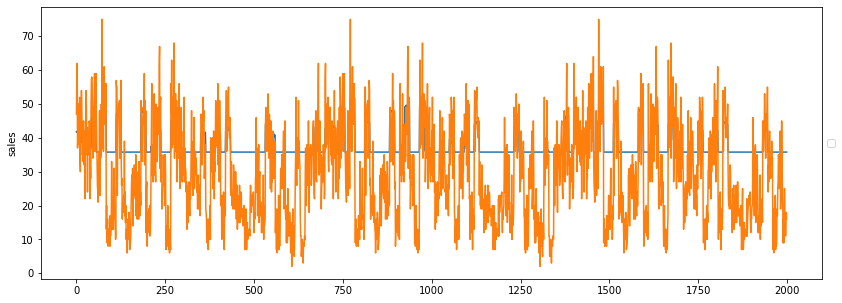

In [253]:
fig = plt.figure(figsize=(14,5))
plt.plot(pred_test_all_recons[:2000, 5])
plt.plot(X_test_seq_reshaped[:2000, 5])

plt.ylabel('sales')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


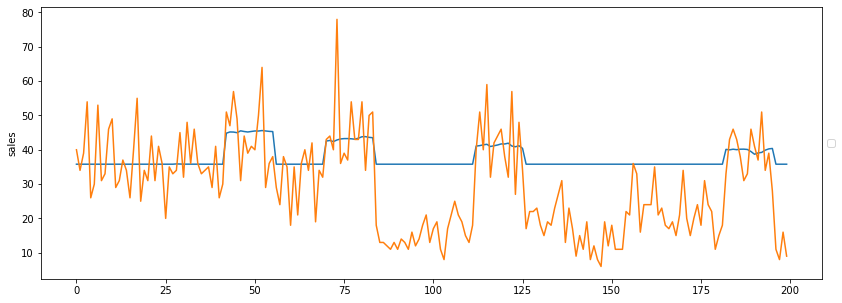

In [254]:
fig = plt.figure(figsize=(14,5))
plt.plot(pred_valid_all_recons[:200, 5])
plt.plot(X_valid_seq_reshaped[:200, 5])

plt.ylabel('sales')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [258]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
class Encoder(layers.Layer):
    """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, ts_sequence_length, num_ts_features, latent_dim=2, intermediate_dim=64, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        #latent_dim = 2

        self.ts_sequence_length = ts_sequence_length
        self.num_ts_features = num_ts_features
        self.inp_seq = keras.Input((self.ts_sequence_length, 10))
        self.inp_lap = keras.Input((10, 10))
        self.inp_feat = keras.Input((10, self.num_ts_features))

        self.encoder_inputs = [self.inp_seq, self.inp_lap, self.inp_feat]
        
        self.gcn_conv1 = GCNConv(32, activation=layers.LeakyReLU(alpha=0.01))
        self.gcn_conv2 = GCNConv(16, activation=layers.LeakyReLU(alpha=0.01))
        self.gcn_conv3 = GCNConv(16, activation=layers.LeakyReLU(alpha=0.01))
        
        self.flatten_layer = layers.Flatten()
        
        self.lstm1 = LSTM(128, activation=layers.LeakyReLU(alpha=0.01), return_sequences=True)
        self.lstm2 = LSTM(64, activation=layers.LeakyReLU(alpha=0.01), return_sequences=True)
        self.lstm3 = LSTM(32, activation=layers.LeakyReLU(alpha=0.01))
        
        self.concat_layer = Concatenate()
        self.batch_norm_layer = BatchNormalization()
        
        self.dropout1 = Dropout(0.1)
        self.fully_connected1 = layers.Dense(intermediate_dim, activation=layers.LeakyReLU(alpha=0.01))
        self.dropout2 = Dropout(0.1)
        
        self.dense_mean = layers.Dense(latent_dim, name="z_mean")
        self.dense_log_var = layers.Dense(latent_dim, name="z_log_var")
        self.sampling = Sampling()

    def call(self, inputs):
        self.inp_seq = inputs[0]
        self.inp_feat = inputs[2]
        self.inp_lap = inputs[1]
        
        x = self.gcn_conv1([self.inp_feat, self.inp_lap])
        x = self.gcn_conv2([x, self.inp_lap])
        x = self.gcn_conv3([x, self.inp_lap])
        
        x = self.flatten_layer(x)

        xx = self.lstm1(self.inp_seq)
        xx = self.lstm2(xx)
        xx = self.lstm3(xx)
        
        x = self.concat_layer([x,xx])
        x = self.batch_norm_layer(x)
        x = self.dropout1(x)
        x = self.fully_connected1(x)
        x = self.dropout2(x)

        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))

        return z_mean, z_log_var, z


class Decoder(layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""

    def __init__(self, original_dim, latent_dim=2, intermediate_dim=64, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)        
        self.latent_inputs = keras.Input(shape=(latent_dim,))
        
        self.fully_connected_lstm = layers.Dense(28, activation=layers.LeakyReLU(alpha=0.01))
        self.reshape_layer_lstm = layers.Reshape((14, 2))
        self.lstm_layer1 = LSTM(128, activation=layers.LeakyReLU(alpha=0.01))
        self.lstm_layer2 = LSTM(10, activation=layers.LeakyReLU(alpha=0.01), return_sequences=True)
        self.lstm_layer3 = LSTM(10, activation=layers.LeakyReLU(alpha=0.01), return_sequences=True)
        
        self.fully_connected_gcn1 = layers.Dense(160, activation=layers.LeakyReLU(alpha=0.01))
        self.fully_connected_lap1 = layers.Dense(100, activation=layers.LeakyReLU(alpha=0.01))
        
        self.reshape_layer_gcn = layers.Reshape((10, 16))
        self.reshape_layer_lap = layers.Reshape((10, 10))
        
        
        self.gcn_layer1 = GCNConv(32, activation=layers.LeakyReLU(alpha=0.01))
        self.gcn_layer2 = GCNConv(16, activation=layers.LeakyReLU(alpha=0.01))
        self.gcn_layer3 = GCNConv(7, activation=layers.LeakyReLU(alpha=0.01))

    def call(self, inputs):
        x_lstm = self.fully_connected_lstm(inputs)
        x_lstm = self.reshape_layer_lstm(x_lstm)

        x_lstm = self.lstm_layer2(x_lstm)
        x_lstm = self.lstm_layer3(x_lstm)

        x_lap = self.fully_connected_lap1(inputs)
        x_lap = self.reshape_layer_lap(x_lap)
        
        x_gnn = self.fully_connected_gcn1(inputs)
        x_gnn = self.reshape_layer_gcn(x_gnn)
        x_gnn = self.gcn_layer1([x_gnn, x_lap])
        x_gnn = self.gcn_layer2([x_gnn, x_lap])
        x_gnn = self.gcn_layer3([x_gnn, x_lap])
        return x_lstm, x_lap, x_gnn

class VAE(keras.Model):
    def __init__(self, 
                 original_dim,
                 ts_sequence_length,
                 num_ts_features,
                 intermediate_dim=64,
                 latent_dim=2,
                 name="variational-autoencoder",
                 **kwargs):
        super(VAE, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(ts_sequence_length=ts_sequence_length, num_ts_features=num_ts_features, latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        #self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        #self.reconstruction_loss_tracker = keras.metrics.Mean(
        #    name="reconstruction_loss"
        #)
        #self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    #@property
    #def metrics(self):
    #    return [
    #        self.total_loss_tracker,
    #        self.reconstruction_loss_tracker,
    #        self.kl_loss_tracker,
    #    ]

    def call(self, inputs):
        #with tf.GradientTape() as tape:
        z_mean, z_log_var, z = self.encoder(inputs)
        #print(data[0][0])
        reconstruction = self.decoder(z)
        #print(reconstruction[0])
        #reconstruction_loss = tf.reduce_mean(
        #    tf.reduce_sum(
        #        keras.losses.binary_crossentropy(data[0][0], reconstruction[0]), axis=(1)
        #    )
        #)
        #reconstruction_loss += tf.reduce_mean(
        #    tf.reduce_sum(
        #        keras.losses.binary_crossentropy(data[0][1], reconstruction[1]), axis=(1)
        #    )
        #)
        #reconstruction_loss += tf.reduce_mean(
        #    tf.reduce_sum(
        #        keras.losses.binary_crossentropy(data[0][2], reconstruction[2]), axis=(1)
        #    )
        #)
        #kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        #kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        #total_loss = reconstruction_loss + kl_loss

        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        #grads = tape.gradient(total_loss, self.trainable_weights)
        #self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        #self.total_loss_tracker.update_state(total_loss)
        #self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        #self.kl_loss_tracker.update_state(kl_loss)

        self.add_loss(kl_loss)
        return reconstruction

In [368]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
class Encoder(layers.Layer):
    """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, ts_sequence_length, num_ts_features, latent_dim=2, intermediate_dim=64, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        #latent_dim = 2

        self.ts_sequence_length = ts_sequence_length
        self.num_ts_features = num_ts_features
        self.inp_seq = keras.Input((self.ts_sequence_length, 10))
        self.inp_lap = keras.Input((10, 10))
        self.inp_feat = keras.Input((10, self.num_ts_features))

        self.encoder_inputs = [self.inp_seq, self.inp_lap, self.inp_feat]
        
        self.gcn_conv1 = GCNConv(16, activation="sigmoid")
        
        self.flatten_layer = layers.Flatten()
        
        self.lstm1 = LSTM(32, activation="sigmoid", return_sequences=True)
        self.lstm2 = LSTM(16, activation="sigmoid")
        
        self.concat_layer = Concatenate()
        self.batch_norm_layer = BatchNormalization()
        
        self.dropout1 = Dropout(0.05)
        self.fully_connected1 = layers.Dense(intermediate_dim, activation="sigmoid")
        self.dropout2 = Dropout(0.05)
        
        self.dense_mean = layers.Dense(latent_dim, name="z_mean")
        self.dense_log_var = layers.Dense(latent_dim, name="z_log_var")
        self.sampling = Sampling()

    def call(self, inputs):
        self.inp_seq = inputs[0]
        self.inp_feat = inputs[2]
        self.inp_lap = inputs[1]
        
        x = self.gcn_conv1([self.inp_feat, self.inp_lap])
        
        x = self.flatten_layer(x)

        xx = self.lstm1(self.inp_seq)
        xx = self.lstm2(xx)
        
        x = self.concat_layer([x,xx])
        x = self.batch_norm_layer(x)
        x = self.dropout1(x)
        x = self.fully_connected1(x)
        x = self.dropout2(x)

        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))

        return z_mean, z_log_var, z


class Decoder(layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""

    def __init__(self, original_dim, ts_sequence_length, latent_dim=2, intermediate_dim=64, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)        
        self.latent_inputs = keras.Input(shape=(latent_dim,))
        
        self.ts_sequence_length = ts_sequence_length

        
        self.fully_connected_lstm = layers.Dense(self.ts_sequence_length * 2, activation="sigmoid")
        self.reshape_layer_lstm = layers.Reshape((self.ts_sequence_length, 2))
        #self.lstm_layer1 = LSTM(4, activation="sigmoid", return_sequences=True)
        self.lstm_layer2 = LSTM(10, activation="sigmoid", return_sequences=True)
        
        self.fully_connected_gcn1 = layers.Dense(160, activation="sigmoid")
        self.fully_connected_lap1 = layers.Dense(100, activation="sigmoid")
        
        self.reshape_layer_gcn = layers.Reshape((10, 16))
        self.reshape_layer_lap = layers.Reshape((10, 10))
        
        
        self.gcn_layer1 = GCNConv(7, activation="sigmoid")

    def call(self, inputs):
        x_lstm = self.fully_connected_lstm(inputs)
        x_lstm = self.reshape_layer_lstm(x_lstm)

        #x_lstm = self.lstm_layer1(x_lstm)
        x_lstm = self.lstm_layer2(x_lstm)

        x_lap = self.fully_connected_lap1(inputs)
        x_lap = self.reshape_layer_lap(x_lap)
        
        x_gnn = self.fully_connected_gcn1(inputs)
        x_gnn = self.reshape_layer_gcn(x_gnn)
        x_gnn = self.gcn_layer1([x_gnn, x_lap])
        return x_lstm, x_lap, x_gnn

class VAE(keras.Model):
    def __init__(self, 
                 original_dim,
                 ts_sequence_length,
                 num_ts_features,
                 intermediate_dim=64,
                 latent_dim=2,
                 name="variational-autoencoder",
                 **kwargs):
        super(VAE, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(ts_sequence_length=ts_sequence_length, num_ts_features=num_ts_features, latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, ts_sequence_length=ts_sequence_length, latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        #self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        #self.reconstruction_loss_tracker = keras.metrics.Mean(
        #    name="reconstruction_loss"
        #)
        #self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    #@property
    #def metrics(self):
    #    return [
    #        self.total_loss_tracker,
    #        self.reconstruction_loss_tracker,
    #        self.kl_loss_tracker,
    #    ]

    def call(self, inputs):
        #with tf.GradientTape() as tape:
        z_mean, z_log_var, z = self.encoder(inputs)
        #print(data[0][0])
        reconstruction = self.decoder(z_mean)
        #print(reconstruction[0])
        #reconstruction_loss = tf.reduce_mean(
        #    tf.reduce_sum(
        #        keras.losses.binary_crossentropy(data[0][0], reconstruction[0]), axis=(1)
        #    )
        #)
        #reconstruction_loss += tf.reduce_mean(
        #    tf.reduce_sum(
        #        keras.losses.binary_crossentropy(data[0][1], reconstruction[1]), axis=(1)
        #    )
        #)
        #reconstruction_loss += tf.reduce_mean(
        #    tf.reduce_sum(
        #        keras.losses.binary_crossentropy(data[0][2], reconstruction[2]), axis=(1)
        #    )
        #)
        #kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        #kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        #total_loss = reconstruction_loss + kl_loss

        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        #grads = tape.gradient(total_loss, self.trainable_weights)
        #self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        #self.total_loss_tracker.update_state(total_loss)
        #self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        #self.kl_loss_tracker.update_state(kl_loss)

        self.add_loss(kl_loss)
        return reconstruction

In [ ]:
y_true = np.array([[0, 1], [0, 0]])
y_true2 = np.array([[0, 1, 2], [0, 0, 2]])

y_pred = np.array([[-18.6, 0.51], [2.94, -12.8]])
y_pred2 = np.array([[-18.6, 0.51, 0.67], [2.94, -12.8, 0.89]])

# Using default 'auto'/'sum_over_batch_size' reduction type.
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bce([y_true, y_true2], [y_pred, y_pred2]).numpy()

In [341]:
X_train_seq.shape

(34150, 48, 10)

In [369]:
def get_model():
    vae = VAE(original_dim = 2, latent_dim = 32, ts_sequence_length=sequence_length, num_ts_features=7)
    vae.compile(optimizer=keras.optimizers.Adam(0.001), loss='mse', 
                      metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return vae

In [357]:
X_valid_seq.shape

(15900, 48, 10)

In [370]:
### TRAIN A MODEL FOR EACH STORES USING ALL THE DATA AVAILALBE FROM OTHER STORES ###

es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

model = get_model()
#print(model.summary())
model.fit([X_train_seq, X_train_lap, X_train_feat], [X_train_seq, X_train_lap, X_train_feat], epochs=100, batch_size=256, 
          validation_data=([X_valid_seq, X_valid_lap, X_valid_feat], [X_valid_seq, X_valid_lap, X_valid_feat]), callbacks=[es], verbose=2)

pred_valid_all = model.predict([X_valid_seq, X_valid_lap, X_valid_feat])
pred_test_all = model.predict([X_test_seq, X_test_lap, X_test_feat])


pred_valid_all_recons = scaler_seq.inverse_transform(pred_valid_all[0].reshape(-1,10)).reshape(pred_valid_all[0].shape)
#reverse_valid = scaler_seq.inverse_transform(y_valid)
pred_test_all_recons = scaler_seq.inverse_transform(pred_test_all[0].reshape(-1,10)).reshape(pred_test_all[0].shape)
#reverse_test = scaler_seq.inverse_transform(y_test)

Epoch 1/100
134/134 - 17s - loss: 2.1185 - output_1_loss: 1.0802 - output_2_loss: 0.0881 - output_3_loss: 0.8518 - output_1_root_mean_squared_error: 1.0393 - output_2_root_mean_squared_error: 0.2969 - output_3_root_mean_squared_error: 0.9229 - val_loss: 2.0699 - val_output_1_loss: 1.2223 - val_output_2_loss: 0.0746 - val_output_3_loss: 0.7335 - val_output_1_root_mean_squared_error: 1.1056 - val_output_2_root_mean_squared_error: 0.2732 - val_output_3_root_mean_squared_error: 0.8564 - 17s/epoch - 127ms/step
Epoch 2/100
134/134 - 11s - loss: 1.6969 - output_1_loss: 1.0260 - output_2_loss: 0.0604 - output_3_loss: 0.5615 - output_1_root_mean_squared_error: 1.0129 - output_2_root_mean_squared_error: 0.2458 - output_3_root_mean_squared_error: 0.7494 - val_loss: 1.9907 - val_output_1_loss: 1.2166 - val_output_2_loss: 0.0501 - val_output_3_loss: 0.7009 - val_output_1_root_mean_squared_error: 1.1030 - val_output_2_root_mean_squared_error: 0.2238 - val_output_3_root_mean_squared_error: 0.8372 - 1

In [371]:
pred_valid_all[0].shape

(15900, 48, 10)

In [372]:
pred_valid_all_recons = np.resize(pred_valid_all_recons, (np.prod(pred_valid_all_recons.shape[:2]), pred_valid_all_recons.shape[-1]))
pred_valid_all_recons.shape

(763200, 10)

In [373]:
pred_test_all_recons = np.resize(pred_test_all_recons, (np.prod(pred_test_all_recons.shape[:2]), pred_test_all_recons.shape[-1]))
pred_test_all_recons.shape

(763200, 10)

In [374]:
X_valid_seq_reshaped = scaler_seq.inverse_transform(X_valid_seq.reshape(-1,10)).reshape(X_valid_seq.shape)

X_valid_seq_reshaped = np.resize(X_valid_seq_reshaped, (np.prod(X_valid_seq_reshaped.shape[:2]), X_valid_seq_reshaped.shape[-1]))
X_valid_seq_reshaped.shape

(763200, 10)

In [375]:
X_test_seq_reshaped = scaler_seq.inverse_transform(X_test_seq.reshape(-1,10)).reshape(X_test_seq.shape)

X_test_seq_reshaped = np.resize(X_test_seq_reshaped, (np.prod(X_test_seq_reshaped.shape[:2]), X_test_seq_reshaped.shape[-1]))
X_test_seq_reshaped.shape

(763200, 10)

In [ ]:
error = {}

for store in range(10):
    
    error[store] = np.sqrt(mean_squared_error(reverse_test[:,store], pred_test_all[:,store]))

In [265]:
### PLOT RMSE ###

plt.figure(figsize=(14,5))
plt.bar(range(10), error.values())
plt.xticks(range(10), ['store_'+str(s) for s in range(10)])
plt.ylabel('error')
np.set_printoptions(False)

NameError: name 'error' is not defined

<Figure size 1008x360 with 0 Axes>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


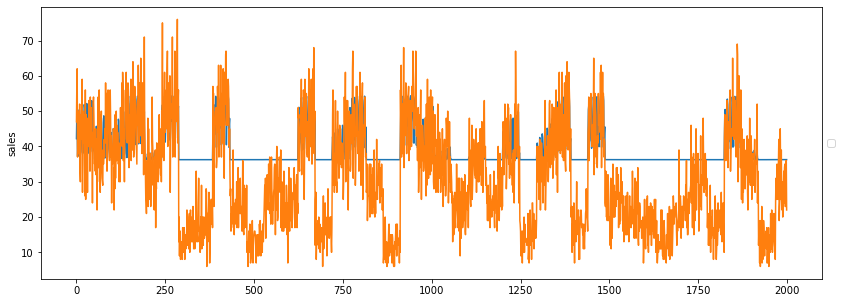

In [376]:
fig = plt.figure(figsize=(14,5))
plt.plot(pred_test_all_recons[:2000, 5])
plt.plot(X_test_seq_reshaped[:2000, 5])

plt.ylabel('sales')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


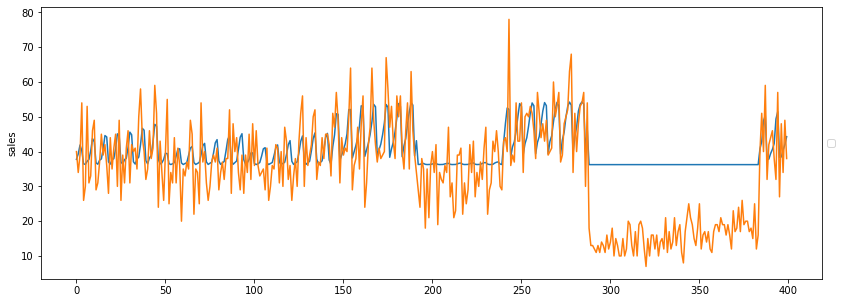

In [377]:
fig = plt.figure(figsize=(14,5))
plt.plot(pred_valid_all_recons[:400, 5])
plt.plot(X_valid_seq_reshaped[:400, 5])

plt.ylabel('sales')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))